## Peak finder
Take in csv file of motif distribution for a cell sample. Detect the regions with enrichment of motif counts within a row of motif distribution.

#### Import library

In [226]:
import csv
import math
import numpy as np
from pf_lib import find_peaks_and_or_valleys, plot_raw_data, plot_peaks_and_valleys
# from file_reader import read_mds_file

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 300em; }</style>"))
# extend the scroll

#### Process the data to gather statistic and plot the peaks and valley 

In [227]:
# method 2: take exponential
def exp_method(raw_row):
    e = math.exp(1)
    exp_list = np.linspace(e, e, len(raw_row))
    exp_data = np.multiply(exp_list,raw_row)
    return exp_data

# method 3: take self power
def power_method(raw_row):
    e = math.exp(1)
    power_data = np.multiply(raw_row,raw_row)
    power_data = np.array(power_data, dtype=np.float64)
    return power_data

# method 4: FFT
def FFT_method(raw_row):
    count = 0
    FFT_data = []
    FFT_data = raw_row
    for i in FFT_data:
        if (float(i)>max(raw_row)*0.5):
            FFT_data[count] = FFT_data[count]
        else:
            FFT_data[count] = 0
        count = count + 1
    return FFT_data
    



def read_mds_file(file_name):
    """Read a MD file that uses Joey's MD file format"""
    
    raw_data = []
    with open(file_name, newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            raw_row = [int(value) for value in row[1:]]
            # the above list comprehension is equivalent to:
    #         raw_row = []
    #         for value in row[1:]:
    #             raw_row.append(int(value))
            raw_data.append(raw_row)
        
            # exp method 
            exp_data = exp_method(raw_row)
            
            # power method
            power_data = power_method(raw_row)
            
            # FFT metohd - there are some bugs here
            # FFT_data = FFT_method(raw_row)
            

    return raw_data


StdDev:  2.4351299784960934 , 1.5 StdDev:  3.6526949677441403 , 2.0 StdDev:  4.870259956992187
Peak properties:  {'peak_heights': array([12.6,  7.4]), 'prominences': array([12.6,  7.4]), 'left_bases': array([120, 152], dtype=int64), 'right_bases': array([139, 166], dtype=int64), 'widths': array([10., 10.]), 'width_heights': array([6.3, 3.7]), 'left_ips': array([126.3375    , 153.74074074]), 'right_ips': array([136.3375    , 163.74074074])}


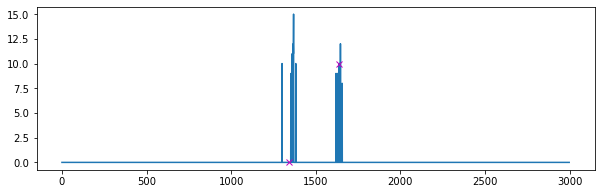

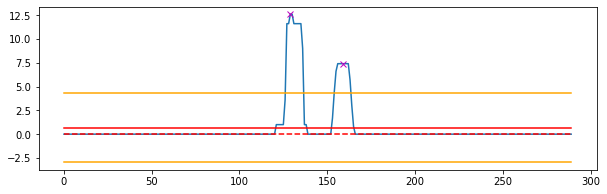

StdDev:  2.5138034393671775 , 1.5 StdDev:  3.7707051590507663 , 2.0 StdDev:  5.027606878734355
Peak properties:  {'peak_heights': array([10.7,  8.3,  6.7]), 'prominences': array([10.7,  8.3,  6.7]), 'left_bases': array([127, 149, 176], dtype=int64), 'right_bases': array([140, 169, 189], dtype=int64), 'widths': array([10., 10., 10.]), 'width_heights': array([5.35, 4.15, 3.35]), 'left_ips': array([128.81521739, 151.87037037, 177.775     ]), 'right_ips': array([138.81521739, 161.87037037, 187.775     ])}


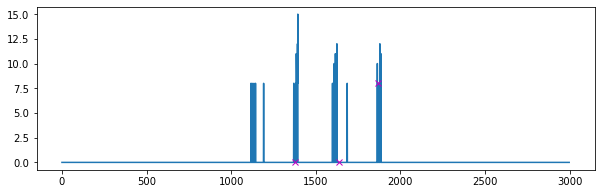

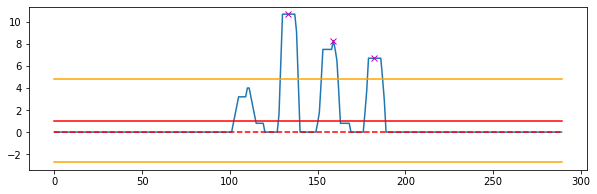

StdDev:  0.6144453867331513 , 1.5 StdDev:  0.921668080099727 , 2.0 StdDev:  1.2288907734663026
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


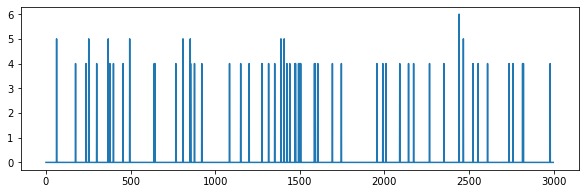

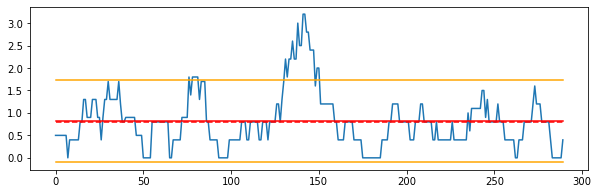

StdDev:  1.4412323539274983 , 1.5 StdDev:  2.1618485308912474 , 2.0 StdDev:  2.8824647078549965
Peak properties:  {'peak_heights': array([7.7, 4. ]), 'prominences': array([7.7, 4. ]), 'left_bases': array([107, 164], dtype=int64), 'right_bases': array([126, 177], dtype=int64), 'widths': array([10., 10.]), 'width_heights': array([3.85, 2.  ]), 'left_ips': array([115.25961538, 164.74074074]), 'right_ips': array([125.25961538, 174.74074074])}


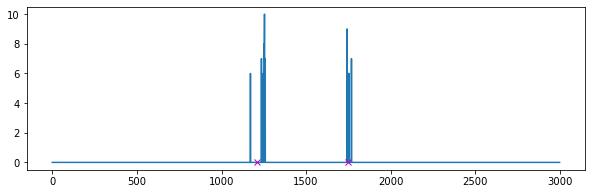

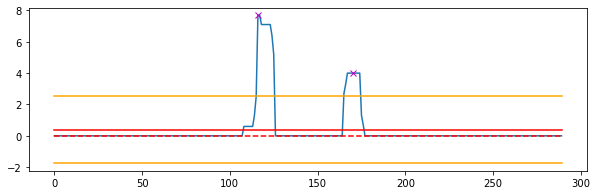

StdDev:  19.581576754499107 , 1.5 StdDev:  29.37236513174866 , 2.0 StdDev:  39.163153508998214
Peak properties:  {'peak_heights': array([75.3, 56.1]), 'prominences': array([75.3, 25.8]), 'left_bases': array([ 90, 140], dtype=int64), 'right_bases': array([185, 185], dtype=int64), 'widths': array([13.36111111, 10.00244798]), 'width_heights': array([37.65, 43.2 ]), 'left_ips': array([124.15123457, 154.57894737]), 'right_ips': array([137.51234568, 164.58139535])}


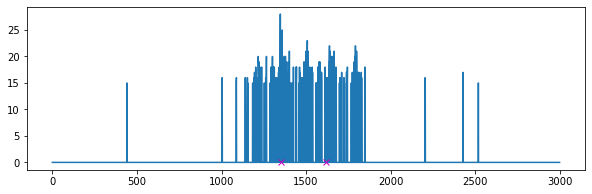

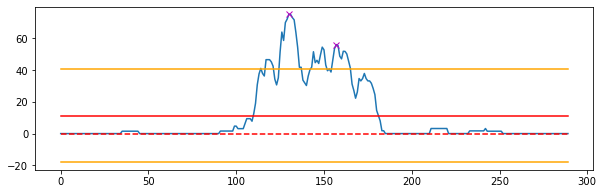

StdDev:  0.6264797778563963 , 1.5 StdDev:  0.9397196667845944 , 2.0 StdDev:  1.2529595557127926
Valley properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


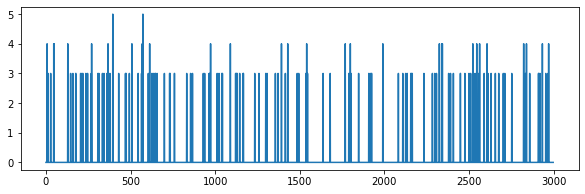

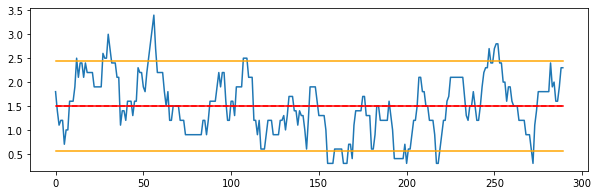

StdDev:  0.345217206206013 , 1.5 StdDev:  0.5178258093090194 , 2.0 StdDev:  0.690434412412026
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


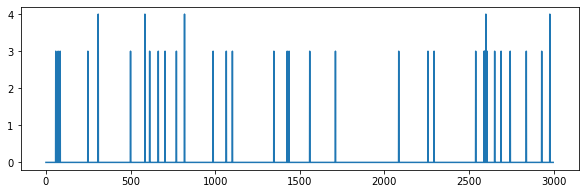

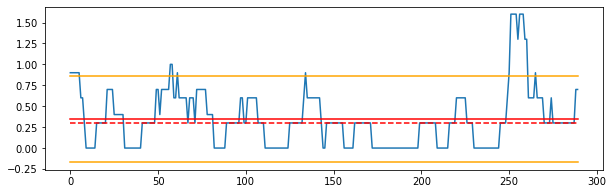

StdDev:  3.9351247170323855 , 1.5 StdDev:  5.902687075548578 , 2.0 StdDev:  7.870249434064771
Peak properties:  {'peak_heights': array([17.3, 14.3, 15.6]), 'prominences': array([12.1,  5.4, 10.7]), 'left_bases': array([  4, 136, 136], dtype=int64), 'right_bases': array([130, 245, 270], dtype=int64), 'widths': array([12.74074074,  9.11111111, 11.01785714]), 'width_heights': array([11.25, 11.6 , 10.25]), 'left_ips': array([  8.87037037, 227.11111111, 251.5       ]), 'right_ips': array([ 21.61111111, 236.22222222, 262.51785714])}
Valley properties:  {'peak_heights': array([16.5, 17.3]), 'prominences': array([ 5.2, 15.6]), 'left_bases': array([15, 15], dtype=int64), 'right_bases': array([106, 253], dtype=int64), 'widths': array([10.88888889, 97.04      ]), 'width_heights': array([13.9,  9.5]), 'left_ips': array([93.11111111, 81.        ]), 'right_ips': array([104.  , 178.04])}


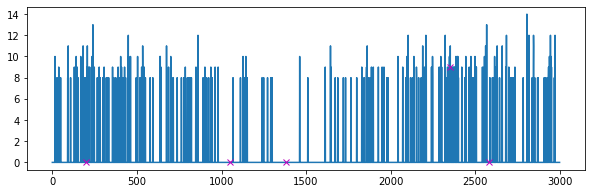

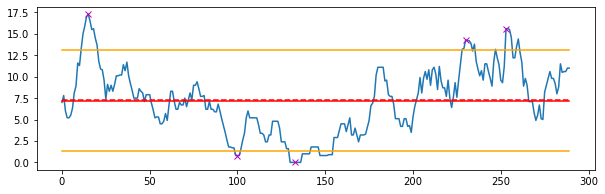

StdDev:  4.438938369205316 , 1.5 StdDev:  6.658407553807974 , 2.0 StdDev:  8.877876738410633
Valley properties:  {'peak_heights': array([17.7]), 'prominences': array([15.2]), 'left_bases': array([43], dtype=int64), 'right_bases': array([274], dtype=int64), 'widths': array([83.4197861]), 'width_heights': array([10.1]), 'left_ips': array([101.22727273]), 'right_ips': array([184.64705882])}


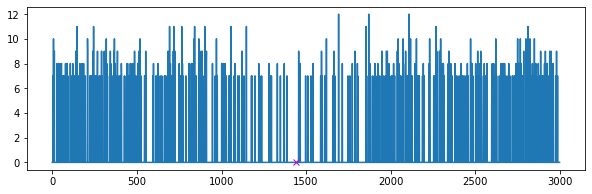

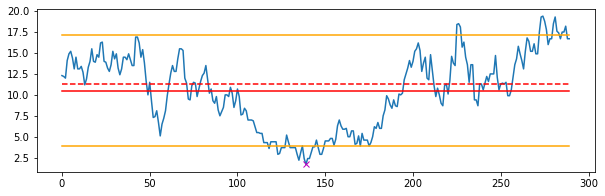

StdDev:  31.01198741520957 , 1.5 StdDev:  46.517981122814355 , 2.0 StdDev:  62.02397483041914
Valley properties:  {'peak_heights': array([120.4]), 'prominences': array([103.]), 'left_bases': array([27], dtype=int64), 'right_bases': array([269], dtype=int64), 'widths': array([69.18699187]), 'width_heights': array([68.9]), 'left_ips': array([111.4796748]), 'right_ips': array([180.66666667])}


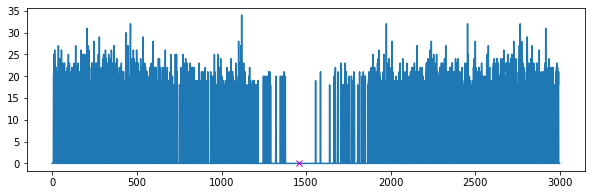

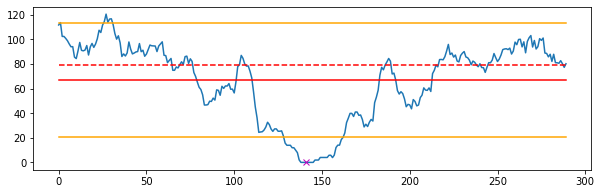

StdDev:  0.3716193517677472 , 1.5 StdDev:  0.5574290276516207 , 2.0 StdDev:  0.7432387035354944
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


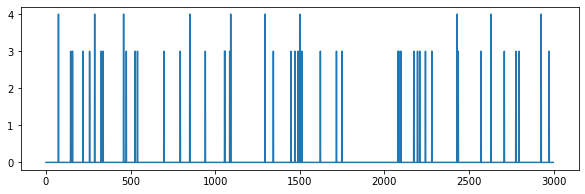

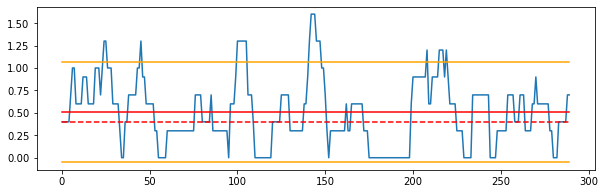

StdDev:  1.418444684838652 , 1.5 StdDev:  2.127667027257978 , 2.0 StdDev:  2.836889369677304
Valley properties:  {'peak_heights': array([6.9, 7. , 6.3]), 'prominences': array([5.8, 6.4, 5.4]), 'left_bases': array([ 27,  27, 125], dtype=int64), 'right_bases': array([ 81, 250, 250], dtype=int64), 'widths': array([42.63636364, 26.46923077, 22.5375    ]), 'width_heights': array([4. , 3.8, 3.6]), 'left_ips': array([ 35.36363636,  90.3       , 174.0625    ]), 'right_ips': array([ 78.        , 116.76923077, 196.6       ])}


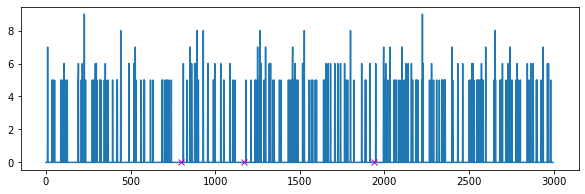

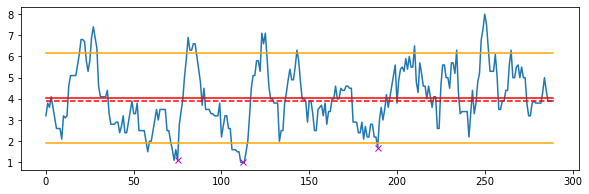

StdDev:  0.4063944207879629 , 1.5 StdDev:  0.6095916311819444 , 2.0 StdDev:  0.8127888415759258
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


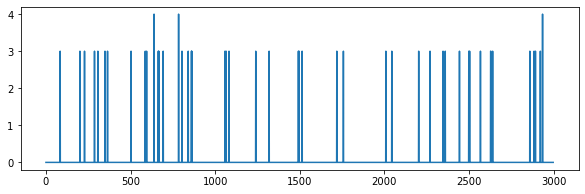

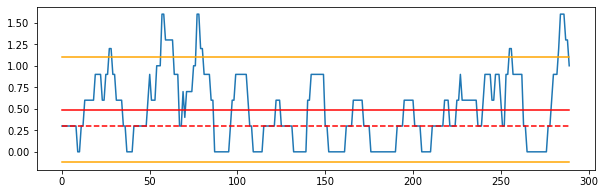

StdDev:  0.4331623696351788 , 1.5 StdDev:  0.6497435544527682 , 2.0 StdDev:  0.8663247392703576
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}
Valley properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


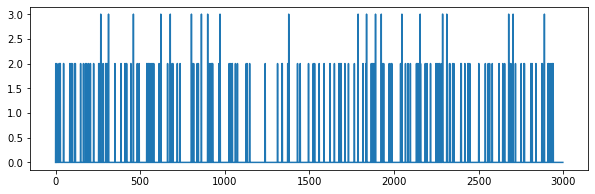

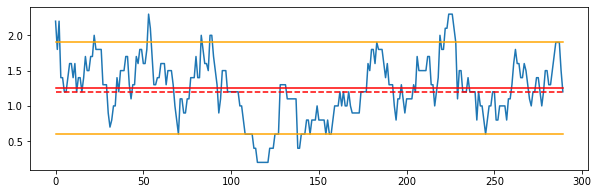

StdDev:  0.18907141886549128 , 1.5 StdDev:  0.2836071282982369 , 2.0 StdDev:  0.37814283773098256
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


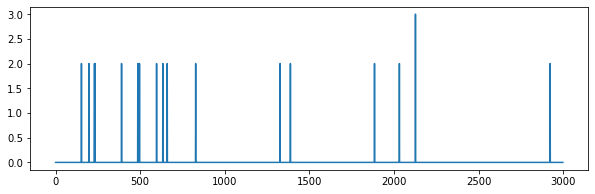

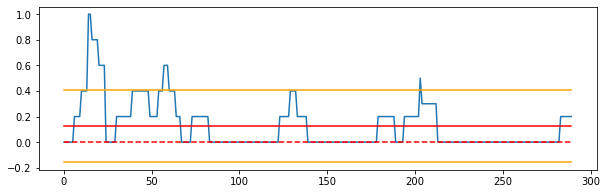

StdDev:  0.35057693598465106 , 1.5 StdDev:  0.5258654039769766 , 2.0 StdDev:  0.7011538719693021
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


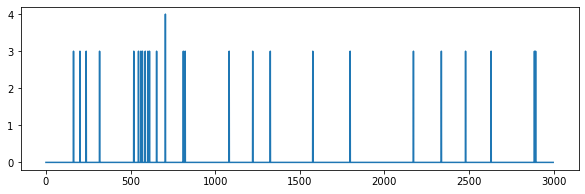

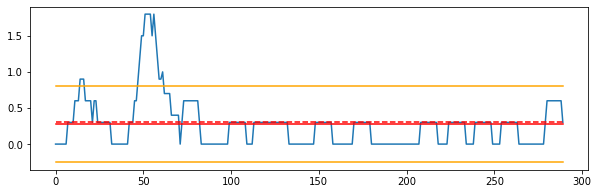

StdDev:  0.9221518517599644 , 1.5 StdDev:  1.3832277776399466 , 2.0 StdDev:  1.8443037035199288
Peak properties:  {'peak_heights': array([4.7]), 'prominences': array([4.7]), 'left_bases': array([205], dtype=int64), 'right_bases': array([256], dtype=int64), 'widths': array([15.625]), 'width_heights': array([2.35]), 'left_ips': array([226.5]), 'right_ips': array([242.125])}


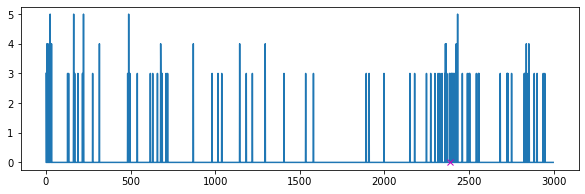

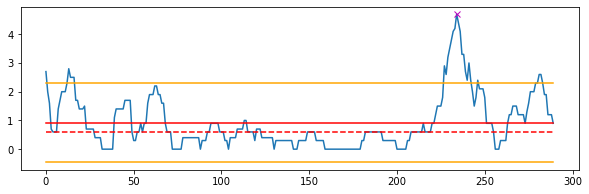

StdDev:  73.65710497617285 , 1.5 StdDev:  110.48565746425928 , 2.0 StdDev:  147.3142099523457
Peak properties:  {'peak_heights': array([401.3]), 'prominences': array([401.3]), 'left_bases': array([129], dtype=int64), 'right_bases': array([163], dtype=int64), 'widths': array([14.29054737]), 'width_heights': array([200.65]), 'left_ips': array([137.68346253]), 'right_ips': array([151.9740099])}


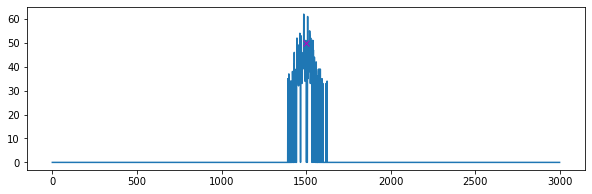

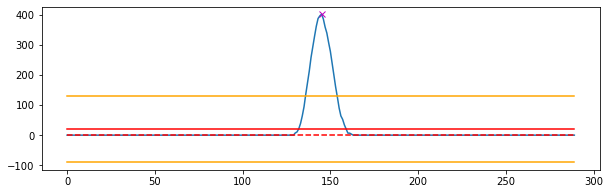

StdDev:  37.58525365364144 , 1.5 StdDev:  56.37788048046215 , 2.0 StdDev:  75.17050730728288
Peak properties:  {'peak_heights': array([212.8]), 'prominences': array([212.8]), 'left_bases': array([129], dtype=int64), 'right_bases': array([161], dtype=int64), 'widths': array([12.75275275]), 'width_heights': array([106.4]), 'left_ips': array([138.64814815]), 'right_ips': array([151.4009009])}


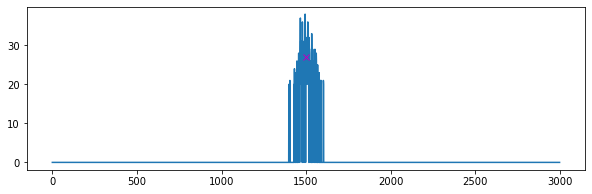

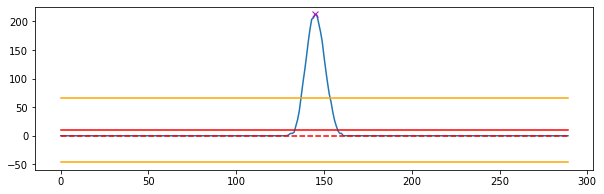

StdDev:  1.786570298858846 , 1.5 StdDev:  2.679855448288269 , 2.0 StdDev:  3.573140597717692
Peak properties:  {'peak_heights': array([9.7]), 'prominences': array([9.7]), 'left_bases': array([124], dtype=int64), 'right_bases': array([168], dtype=int64), 'widths': array([14.22916667]), 'width_heights': array([4.85]), 'left_ips': array([139.45833333]), 'right_ips': array([153.6875])}


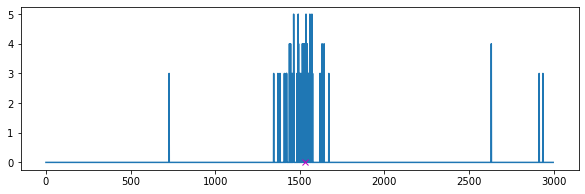

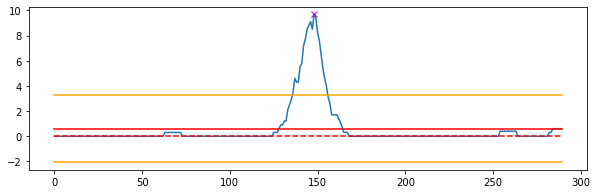

StdDev:  0.44916087960131684 , 1.5 StdDev:  0.6737413194019752 , 2.0 StdDev:  0.8983217592026337
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


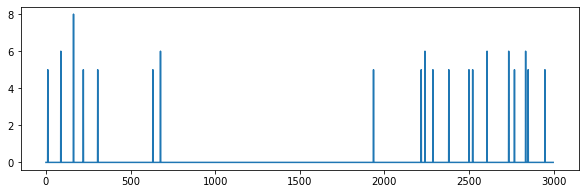

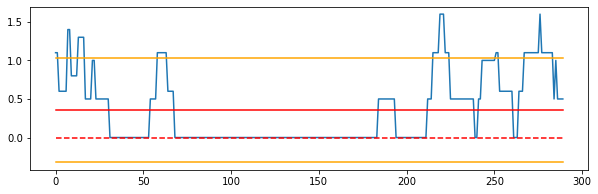

StdDev:  2.3862140349003833 , 1.5 StdDev:  3.5793210523505747 , 2.0 StdDev:  4.772428069800767
Peak properties:  {'peak_heights': array([ 8.1, 10.4]), 'prominences': array([4.4, 4.6]), 'left_bases': array([  6, 162], dtype=int64), 'right_bases': array([140, 274], dtype=int64), 'widths': array([12.25      , 10.44886364]), 'width_heights': array([5.9, 8.1]), 'left_ips': array([ 10.375 , 259.1875]), 'right_ips': array([ 22.625     , 269.63636364])}


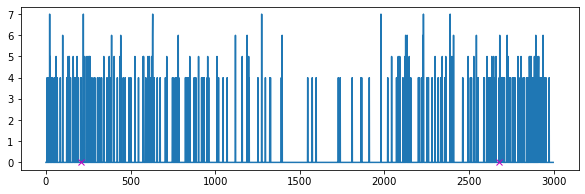

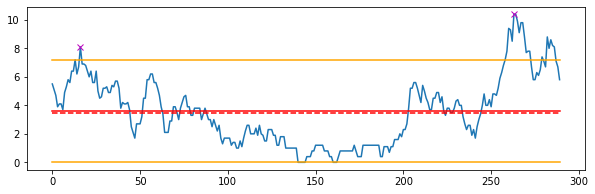

StdDev:  0.768614135193954 , 1.5 StdDev:  1.152921202790931 , 2.0 StdDev:  1.537228270387908
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


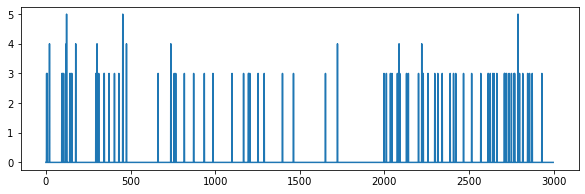

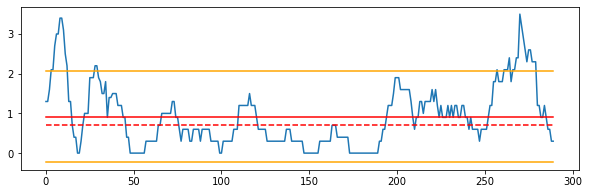

StdDev:  0.9798449114990707 , 1.5 StdDev:  1.469767367248606 , 2.0 StdDev:  1.9596898229981414
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}
Valley properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


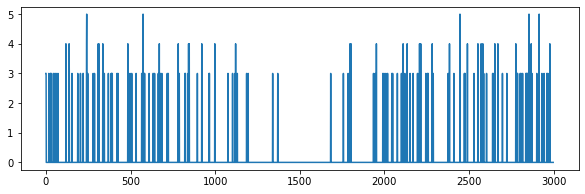

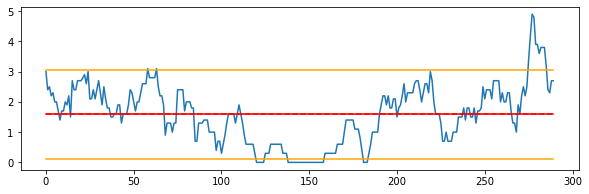

StdDev:  1.230716961995766 , 1.5 StdDev:  1.8460754429936492 , 2.0 StdDev:  2.461433923991532
Peak properties:  {'peak_heights': array([6.1]), 'prominences': array([4.5]), 'left_bases': array([163], dtype=int64), 'right_bases': array([287], dtype=int64), 'widths': array([11.87857143]), 'width_heights': array([3.85]), 'left_ips': array([267.05]), 'right_ips': array([278.92857143])}


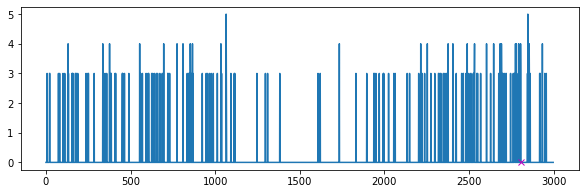

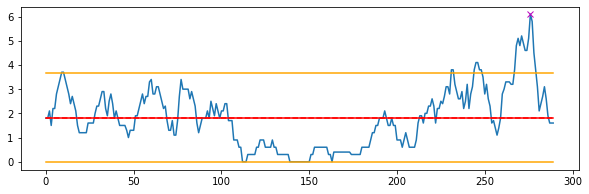

StdDev:  0.49389302341472224 , 1.5 StdDev:  0.7408395351220833 , 2.0 StdDev:  0.9877860468294445
Peak properties:  {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)}


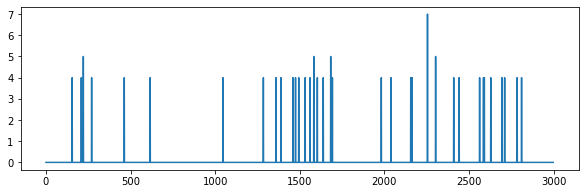

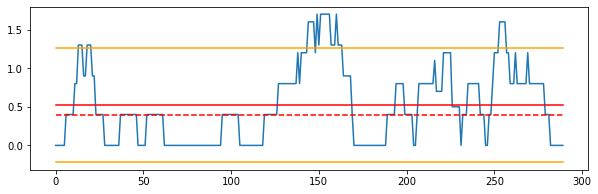

StdDev:  12.038497037815118 , 1.5 StdDev:  18.057745556722676 , 2.0 StdDev:  24.076994075630235
Peak properties:  {'peak_heights': array([84.9, 92. ]), 'prominences': array([37.9, 64.1]), 'left_bases': array([84, 84], dtype=int64), 'right_bases': array([142, 197], dtype=int64), 'widths': array([ 9.55176776, 11.26415571]), 'width_heights': array([65.95, 59.95]), 'left_ips': array([129.40184049, 151.28294574]), 'right_ips': array([138.95360825, 162.54710145])}
Valley properties:  {'peak_heights': array([64.1, 61.4, 73.2]), 'prominences': array([33. , 14. , 43.5]), 'left_bases': array([ 21, 106, 159], dtype=int64), 'right_bases': array([159, 159, 245], dtype=int64), 'widths': array([38.35714286,  3.69264706, 14.92030948]), 'width_heights': array([47.6 , 54.4 , 51.45]), 'left_ips': array([ 67.58571429, 108.625     , 188.79787234]), 'right_ips': array([105.94285714, 112.31764706, 203.71818182])}


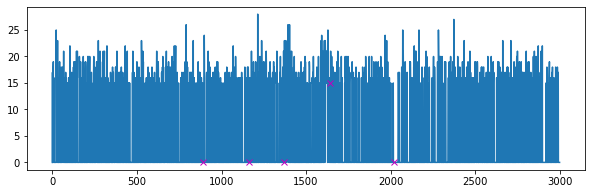

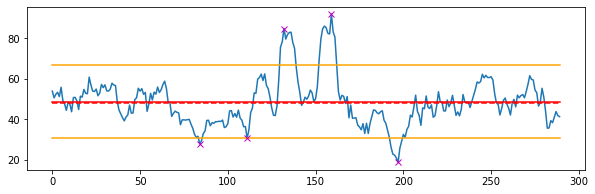

StdDev:  2.013120191489127 , 1.5 StdDev:  3.0196802872336903 , 2.0 StdDev:  4.026240382978254
Peak properties:  {'peak_heights': array([ 8.2, 12.5,  6.5]), 'prominences': array([ 6.9, 11.8,  4.1]), 'left_bases': array([103, 103, 248], dtype=int64), 'right_bases': array([146, 183, 289], dtype=int64), 'widths': array([10.56725146, 10.38738739,  6.32142857]), 'width_heights': array([4.75, 6.6 , 4.45]), 'left_ips': array([124.71052632, 155.66666667, 274.75      ]), 'right_ips': array([135.27777778, 166.05405405, 281.07142857])}


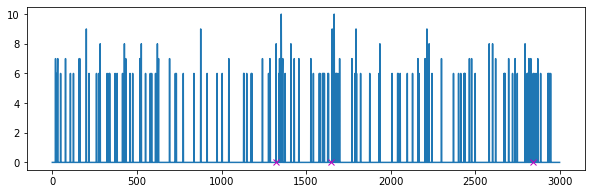

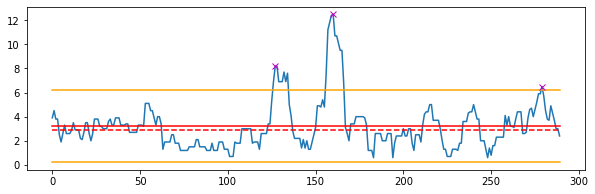

StdDev:  0.5496046457906093 , 1.5 StdDev:  0.8244069686859139 , 2.0 StdDev:  1.0992092915812186


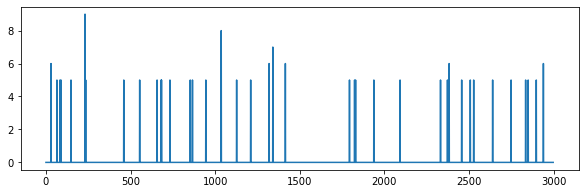

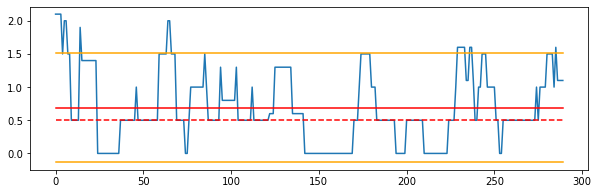

StdDev:  32.79392644046897 , 1.5 StdDev:  49.19088966070346 , 2.0 StdDev:  65.58785288093794
Peak properties:  {'peak_heights': array([304.7, 288.6, 300.4]), 'prominences': array([105.1,  76.3,  99.2]), 'left_bases': array([  6,  96, 146], dtype=int64), 'right_bases': array([146, 146, 286], dtype=int64), 'widths': array([35.30416667, 13.87307004, 23.00757576]), 'width_heights': array([252.15, 250.45, 250.8 ]), 'left_ips': array([ 22.03333333,  99.38302752, 254.15909091]), 'right_ips': array([ 57.3375    , 113.25609756, 277.16666667])}
Valley properties:  {'peak_heights': array([121.7, 142. ]), 'prominences': array([ 38.9, 137.7]), 'left_bases': array([31, 31], dtype=int64), 'right_bases': array([129, 266], dtype=int64), 'widths': array([ 6.86456584, 62.70186651]), 'width_heights': array([102.25,  73.15]), 'left_ips': array([117.29581152, 114.53867403]), 'right_ips': array([124.16037736, 177.24054054])}


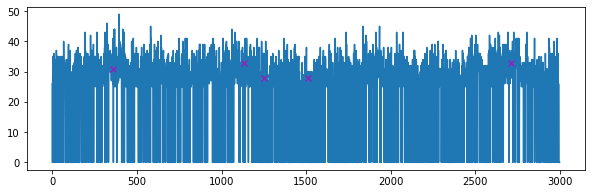

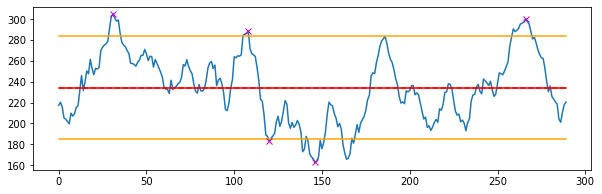

In [228]:
# TODO config
file_name = 'SRR574824_filtereddata.csv'
reduce_size = 10 
smooth_size = 10

raw_data = read_mds_file(file_name)

    
for raw_row in raw_data:
    reduced_row, peaks, valleys, peak_properties, valley_properties = find_peaks_and_or_valleys(raw_row, reduce_size, smooth_size)
    peaks_bp = []
    for old_loc in peaks:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        peaks_bp.append(new_loc)
    valleys_bp = []
    for old_loc in valleys:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        valleys_bp.append(new_loc)
    plot_raw_data(raw_row, peaks_bp, valleys_bp)
    plot_peaks_and_valleys(reduced_row, peaks, valleys)